## Scratch notebook for testing GCN dataloader and t-SNE

In [ ]:
from hires_dataset import HiRESDataset

import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# hyperparams
BATCH_SIZE = 4
NUM_EPOCHS = 10
LR = 0.01
WEIGHT_DECAY = 0.0
HIDDEN_1, HIDDEN_2, OUT_CHANNELS = 128, 128, 10

In [ ]:
dataset = HiRESDataset(root="/nfs/turbo/dcmb-class/bioinf593/groups/group_08/datasets/brains/")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### t-SNE for Hi-C

In [5]:
from karateclub import DeepWalk
from sklearn.manifold import TSNE
import networkx as nx
import pandas as pd
import hicstraw
import matplotlib.pyplot as plt
import numpy as np
import os

In [18]:
def read_hic_file(filename, chrom, resolution, positions, data_type, normalization="NONE", max_matrix_size=False, verbose=True):
    '''
    filename (str) : path to .hic file
    chrom (str) : specify chromosome (e.g., "chr3") – also printed if verbose=True
    positions (int, int) : tuple of start and end 1-indexed basepair resolution, or "all"
    data_type (str) = ["observed", "oe"] : according to hicstraw documentation 
    normalization (str) = ["NONE", "VC", "VC_SQRT", "KR", "SCALE"]: according to hicstraw documentation 
    max_matrix_size (int or False)
        Default is False (normal)
        Otherwise, this reads a Hi-C in chunks of size (`max_matrix_size` - 1) to avoid crashes due to limited RAM 
        (note: if max_matrix_size is too small then performance takes a hit)
        
        max_matrix_size = 2000 is roughly appropriate for a system with 32GB RAM 
    '''
    hic = hicstraw.HiCFile(filename)
    if verbose:
        print("Identified")
        print("Possible resolutions")
        for possible_res in hic.getResolutions():
            print(" * {}".format(possible_res))
        print("Chrom name : Chrom size:")
    found = False
    start_pos = 0
    end_pos = -1
    for chromosome in hic.getChromosomes():
        if verbose:
            print("  -", chromosome.name, chromosome.length, end="")
        
        if str(chrom) == chromosome.name:
            key = chromosome.name
            found = True
            end_pos = chromosome.length
            if verbose:
                print(" <- Selected", end="")
                
        if verbose:
            print()
        
    if not found:
        print("Chromosome '{}' could not be identified. Check again.".format(chrom))
        return
    
    mzd = hic.getMatrixZoomData(key, key, data_type, normalization, "BP", int(resolution))
    
    if positions != "all":
        start_pos = positions[0]
        end_pos = positions[1]
        
    if max_matrix_size:
        binned_size = np.ceil((end_pos - start_pos) / resolution).astype(int)
        return read_hic_efficiently(mzd, binned_size, resolution, max_matrix_size, verbose)
        
    return mzd.getRecordsAsMatrix(start_pos, end_pos, start_pos, end_pos)

In [17]:
print(len(os.listdir('/nfs/turbo/dcmb-class/bioinf593/groups/group_08/processed/Brains/hi_c')))

426


In [25]:
# single cell hi-c contact matrix (chr3, 100kbp resolution)
D = np.zeros((426, 1280800))
dir = '/nfs/turbo/dcmb-class/bioinf593/groups/group_08/processed/Brains/hi_c'
for i, f in enumerate(os.listdir(dir)):
    print(i)
    A = read_hic_file(filename=(dir + '/' + f),
                    chrom="chr3", # Chromosome 3
                    resolution=int(1e5), # 1 Mbp resolution
                    positions="all", # All positions of chromosome 3
                    data_type="oe", # Observed over expected normalization
                    normalization="KR",  # KR matrix balancing – Good default parameter (just makes this matrix have equal row and column sums)
                    max_matrix_size=False, 
                    verbose=True)
    if A.shape[0] != 1280800:
        continue
    D[i] = A[np.triu_indices(A.shape[0], k=1)]

0
Identified
Possible resolutions
 * 1000000
 * 100000
 * 20000
Chrom name : Chrom size:
  - All 2725537
  - chr1 195471971
  - chr2 182113224
  - chr3 160039680 <- Selected
  - chr4 156508116
  - chr5 151834684
  - chr6 149736546
  - chr7 145441459
  - chr8 129401213
  - chr9 124595110
  - chr10 130694993
  - chr11 122082543
  - chr12 120129022
  - chr13 120421639
  - chr14 124902244
  - chr15 104043685
  - chr16 98207768
  - chr17 94987271
  - chr18 90702639
  - chr19 61431566
  - chrM 16299
  - chrX 171031299
  - chrY 91744698
1
Identified
Possible resolutions
 * 1000000
 * 100000
 * 20000
Chrom name : Chrom size:
  - All 2725537
  - chr1 195471971
  - chr2 182113224
  - chr3 160039680 <- Selected
  - chr4 156508116
  - chr5 151834684
  - chr6 149736546
  - chr7 145441459
  - chr8 129401213
  - chr9 124595110
  - chr10 130694993
  - chr11 122082543
  - chr12 120129022
  - chr13 120421639
  - chr14 124902244
  - chr15 104043685
  - chr16 98207768
  - chr17 94987271
  - chr18 90702639

In [26]:
D.shape

(426, 1280800)

In [ ]:
import pandas as pd

META_FILENAME = '/nfs/turbo/dcmb-class/bioinf593/groups/group_08/raw/rna_seq/GSE223917_HiRES_brain_metadata.xlsx'
meta = pd.read_excel(META_FILENAME, engine='openpyxl')

In [ ]:
# collect node embeddings
model = DeepWalk()
G = nx.from_numpy_matrix(D)
model.fit(G)
embedding = model.get_embedding()

In [28]:
# perform t-SNE
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')
embedding2d = tsne.fit_transform(D)

/nfs/turbo/dcmb-class/bioinf593/groups/group_08/env/lib64/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [29]:
embeddingDF = pd.DataFrame()
# embeddingDF['proteins'] = proteinAnnodf['preferred_name']
embeddingDF['x'] = embedding2d[:,0] # Extracting first dimension of reduced dimensionality embedding
embeddingDF['y'] = embedding2d[:,1] # Second dimension of reduced dimensionality embedding

embeddingDF.head()

,x,y
0,-2.653898,-0.396404
1,0.981540,0.573545
2,0.620326,1.330207
3,-0.703948,1.105433
4,0.253706,1.263973


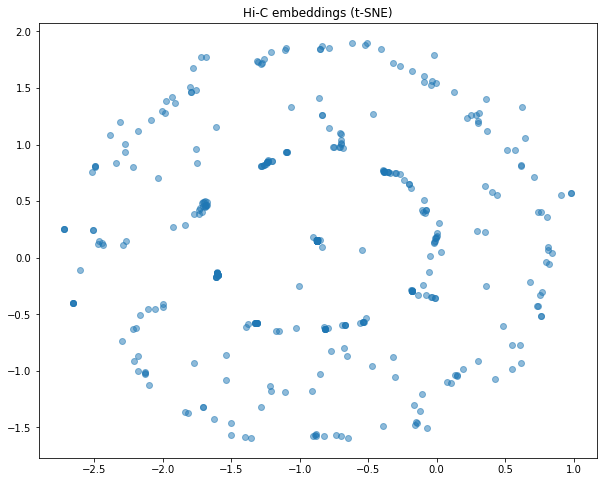

In [30]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(embeddingDF.x, embeddingDF.y, alpha=0.5)

plt.title('Hi-C embeddings (t-SNE)')
plt.show()